# Latincom 2025 - Anomaly Detection in Industrial IoT (IIoT)

Dataset: https://ieee-dataport.org/documents/bruriiot-dataset-network-anomaly-detection-iiot-enhanced-feature-engineering-approach


## 1. Import libraries

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import gc

from pipeline.preprocessing import (
    create_splits_and_save, 
    transform_labels, 
    get_labels_mapping,
    balance_labels_with_smote
)
from pipeline.feature_selection import (
    fs_mutual_information,
    fs_markov_blanket,
    fs_boruta,
    fs_rfe,
    random_features
)
from pipeline.model import train_xgboost
from pipeline.training_size import training_size
from pipeline.utils import get_protocols, filter_module

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

%matplotlib inline

SEED = 10  # 5 seeds: 0, 10, 20, 30 and 40
MODEL_SAVE_DIR = './data/models/'

## 2. Create data splits

Split into training (55%), feature selection (5%), validation (20%) and test (20%)

In [2]:
# load dataset with Polars
df = pl.read_csv('./data/datasets/BRUIIoT.csv')
print('Original dataset size:', df.shape)
print(f'There are {df.shape[0]} total observations.')

# create splits
df_train, df_fs, df_valid, df_test = create_splits_and_save(df, './data/datasets/splits', seed=SEED)

# clear memory
del df
gc.collect()

Original dataset size: (2776422, 267)
There are 2776422 total observations.
Training division: 0.55
Feature Selection division: 0.05
Validation division: 0.2
Test division: 0.2


0

## 3. Preprocess data

### 3.1 Transform labels

In [3]:
# transform labels to normal, mirai, icmp, syn and others
df_train = transform_labels(df_train)
df_fs = transform_labels(df_fs)
df_valid = transform_labels(df_valid)
df_test = transform_labels(df_test)

In [4]:
# check labels
get_labels_mapping(df_train)

{0: 'normal',
 1: 'Mirai-greeth_flood',
 2: 'ddos_icmp_flood',
 3: 'ddos_syn_flood',
 4: 'other_attack_type'}

### 3.2 Balance training labels

Text(0.5, 1.0, 'Attack types distribution - training (before preprocessing)')

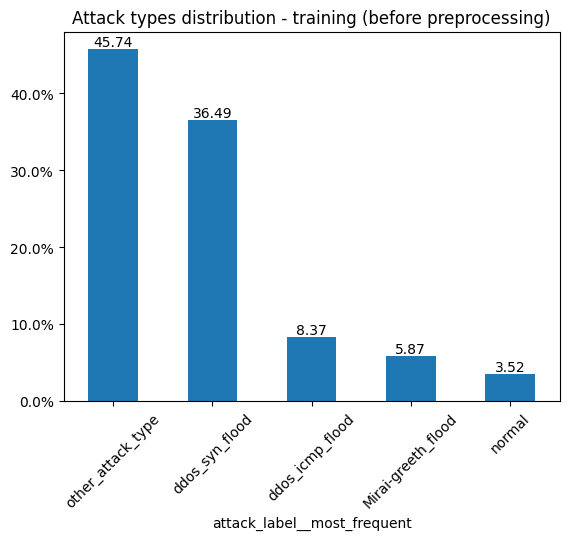

In [5]:
ax = df_train['attack_label__most_frequent'].to_pandas().value_counts(normalize=True).apply(lambda x: round(x*100, 2)).plot.bar(rot=45)

# add bar's labels
for container in ax.containers:
    ax.bar_label(container)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.title('Attack types distribution - training (before preprocessing)')

In [6]:
%%time
# balance training labels (SMOTE)
df_train = balance_labels_with_smote(df_train, seed=SEED)
df_train.shape

Has normal label more than 305406 to cut? False
Has mirai label more than 305406 to cut? False
Has icmp label more than 305406 to cut? False
Has syn label more than 305406 to cut? True
Has others label more than 305406 to cut? True
CPU times: user 6min 8s, sys: 12.6 s, total: 6min 21s
Wall time: 2min 17s


(1527030, 265)

Text(0.5, 1.0, 'Attack types distribution - training (after preprocessing)')

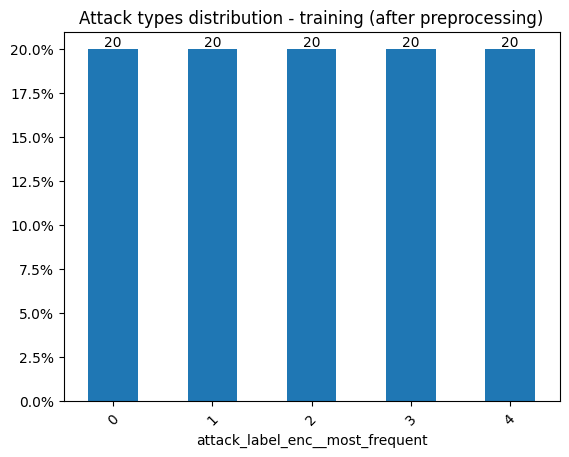

In [7]:
ax = df_train['attack_label_enc__most_frequent'].value_counts(normalize=True).apply(lambda x: round(x*100, 2)).plot.bar(rot=45)

# add bar's labels
for container in ax.containers:
    ax.bar_label(container)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.title('Attack types distribution - training (after preprocessing)')

### 3.3 Save data splits

In [8]:
# save preprocessed splits to disk
df_train.to_csv(f'./data/datasets/splits/BRUIIoT_train_preprocessed_seed{SEED}.csv', index=False)
df_fs.write_csv(f'./data/datasets/splits/BRUIIoT_fs_preprocessed_seed{SEED}.csv')
df_valid.write_csv(f'./data/datasets/splits/BRUIIoT_valid_preprocessed_seed{SEED}.csv')
df_test.write_csv(f'./data/datasets/splits/BRUIIoT_test_preprocessed_seed{SEED}.csv')

In [9]:
del df_train, df_fs, df_valid, df_test
gc.collect()

5

## 4. Determining Sufficient Training set size

In [10]:
# restore preprocessed data splits
df_train = pd.read_csv(f'./data/datasets/splits/BRUIIoT_train_preprocessed_seed{SEED}.csv')
df_valid = pd.read_csv(f'./data/datasets/splits/BRUIIoT_valid_preprocessed_seed{SEED}.csv')

# shuffle training set
df_train = df_train.sample(frac=1, random_state=SEED).reset_index(drop=True)

# label columns
targets_cols = ['attack_label__most_frequent', 'attack_label_enc__most_frequent', 'is_attack__most_frequent']

# labels mapping
labels = get_labels_mapping(df_valid)

In [11]:
# keep only protocol features
df_train = df_train.drop(columns=['frame.time__calculate_duration'])
df_valid = df_valid.drop(columns=['frame.time__calculate_duration'])

# get features and targets from validation
X_valid = df_valid.drop(columns=targets_cols+['index'])
y_valid = df_valid.loc[:, 'attack_label_enc__most_frequent']

print('Training size:', df_train.shape)
print('Validation features size:', X_valid.shape)
print('Validation labels size:', y_valid.shape)

Training size: (1527030, 264)
Validation features size: (555284, 263)
Validation labels size: (555284,)


In [12]:
df_results = training_size(
    df_train, 
    X_valid, y_valid, 
    data_seed=SEED, ml_seed=SEED, 
    model_save_dir=MODEL_SAVE_DIR
)
df_results.to_csv(f'./data/results/training_size/training_size_results_seed{SEED}.csv', index=False)

100%|█████████████████████████████████████████████████████| 20/20 [11:13<00:00, 33.67s/it, prop=100, train_size=1527030]


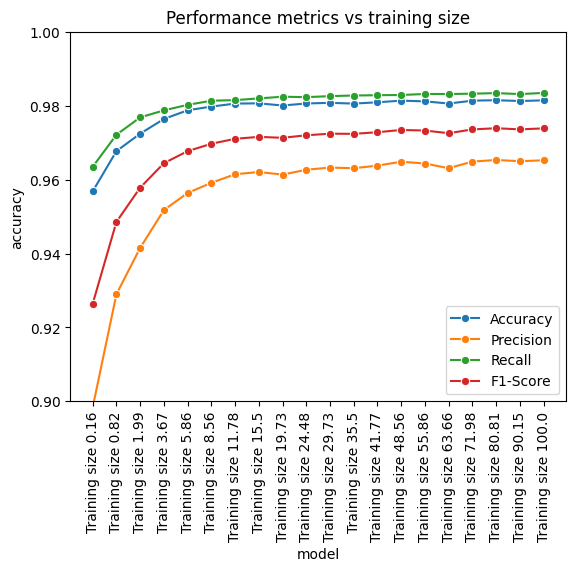

In [13]:
sns.lineplot(df_results, y='accuracy', x='model', label='Accuracy', marker='o')
sns.lineplot(df_results, y='precision', x='model', label='Precision', marker='o')
sns.lineplot(df_results, y='recall', x='model', label='Recall', marker='o')
sns.lineplot(df_results, y='f1-score', x='model', label='F1-Score', marker='o')
plt.xticks(rotation=90)
plt.legend()
plt.ylim((0.9, 1.0))
plt.title('Performance metrics vs training size')
plt.show()

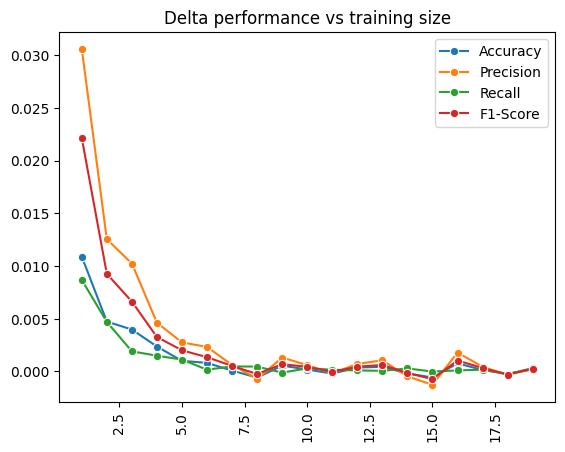

In [14]:
sns.lineplot(df_results['accuracy'].diff().values, label='Accuracy', marker='o')
sns.lineplot(df_results['precision'].diff().values, label='Precision', marker='o')
sns.lineplot(df_results['recall'].diff().values, label='Recall', marker='o')
sns.lineplot(df_results['f1-score'].diff().values, label='F1-Score', marker='o')
plt.xticks(rotation=90)
plt.legend()
plt.title('Delta performance vs training size')
plt.show()

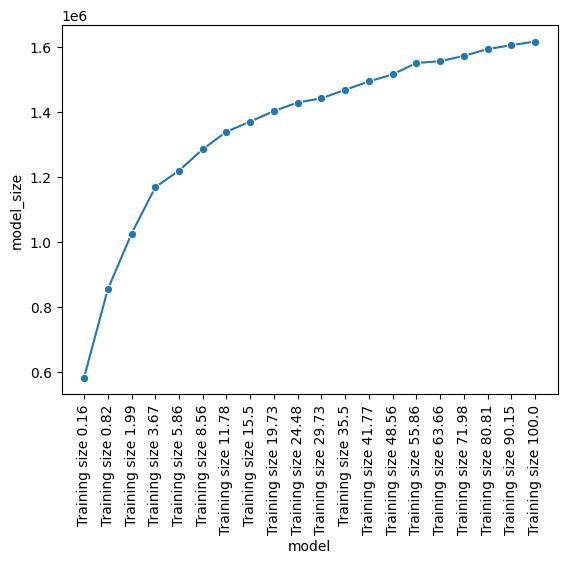

In [15]:
sns.lineplot(df_results, y='model_size', x='model', marker='o')
plt.xticks(rotation=90)
plt.show()

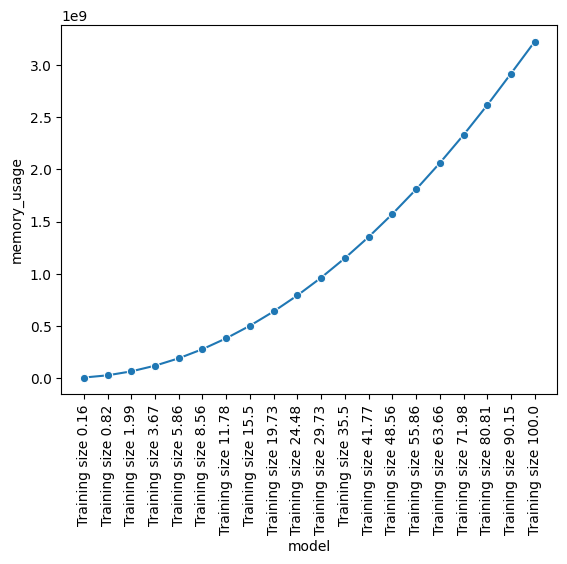

In [16]:
sns.lineplot(df_results, y='memory_usage', x='model', marker='o')
plt.xticks(rotation=90)
plt.show()

In [17]:
# training proportion to sample
training_size_prop = 0.1178

# sufficient training set size
df_train = df_train.sample(frac=training_size_prop, random_state=SEED)

df_train.to_csv(f'./data/datasets/splits/BRUIIoT_train_size{training_size_prop}_seed{SEED}.csv', index=False)

## 5. Feature selection

In [18]:
# restore remaining data splits (fs and test)
df_fs = pd.read_csv(f'./data/datasets/splits/BRUIIoT_fs_preprocessed_seed{SEED}.csv')
df_test = pd.read_csv(f'./data/datasets/splits/BRUIIoT_test_preprocessed_seed{SEED}.csv')

# get procotols
modules = get_protocols(df_fs, targets_cols)

In [19]:
# keep only protocols
# df_train = df_train.drop(columns=['frame.time__calculate_duration'])
df_fs = df_fs.drop(columns=['frame.time__calculate_duration'])
# df_valid = df_valid.drop(columns=['frame.time__calculate_duration'])
df_test = df_test.drop(columns=['frame.time__calculate_duration'])

# get features and targets
X_train = df_train.drop(columns=['attack_label_enc__most_frequent'])
X_fs = df_fs.drop(columns=targets_cols+['index'])
X_valid = df_valid.drop(columns=targets_cols+['index'])
X_test = df_test.drop(columns=targets_cols+['index'])

y_train = df_train.loc[:, 'attack_label_enc__most_frequent']
y_fs = df_fs.loc[:, 'attack_label_enc__most_frequent']
y_valid = df_valid.loc[:, 'attack_label_enc__most_frequent']
y_test = df_test.loc[:, 'attack_label_enc__most_frequent']

print('Training features size:', X_train.shape)
print('FS features size:', X_fs.shape)
print('Validation features size:', X_valid.shape)
print('Test features size:', X_test.shape)
print('')
print('Training labels size:', y_train.shape)
print('FS labels size:', y_fs.shape)
print('Validation labels size:', y_valid.shape)
print('Test labels size:', y_test.shape)

Training features size: (179884, 263)
FS features size: (138821, 263)
Validation features size: (555284, 263)
Test features size: (555284, 263)

Training labels size: (179884,)
FS labels size: (138821,)
Validation labels size: (555284,)
Test labels size: (555284,)


In [20]:
for m in modules:
    print(f'**Processing module {m}...**')

    # get module's columns
    cols = filter_module(df_train.columns, m)
    print(f'Columns length: {len(cols)}, columns:', cols)
    print('')

**Processing module icmp...**
Columns length: 16, columns: ['icmp.checksum__min', 'icmp.checksum__max', 'icmp.checksum__sum', 'icmp.checksum__mean', 'icmp.checksum__min_max_diff', 'icmp.checksum__min_max_ratio', 'icmp.checksum__min_max_product', 'icmp.checksum__mean_square', 'icmp.seq_le__min', 'icmp.seq_le__max', 'icmp.seq_le__sum', 'icmp.seq_le__mean', 'icmp.seq_le__min_max_diff', 'icmp.seq_le__min_max_ratio', 'icmp.seq_le__min_max_product', 'icmp.seq_le__mean_square']

**Processing module mqtt...**
Columns length: 54, columns: ['mqtt.conflag.cleansess__min', 'mqtt.conflag.cleansess__max', 'mqtt.conflag.cleansess__sum', 'mqtt.conflag.cleansess__mean', 'mqtt.conflag.cleansess__min_max_diff', 'mqtt.conflag.cleansess__min_max_ratio', 'mqtt.conflag.cleansess__min_max_product', 'mqtt.conflag.cleansess__mean_square', 'mqtt.conflags__min', 'mqtt.conflags__max', 'mqtt.conflags__sum', 'mqtt.conflags__mean', 'mqtt.conflags__nunique', 'mqtt.conflags__min_max_diff', 'mqtt.conflags__min_max_ratio

### 5.1 Mutual Information (MI)

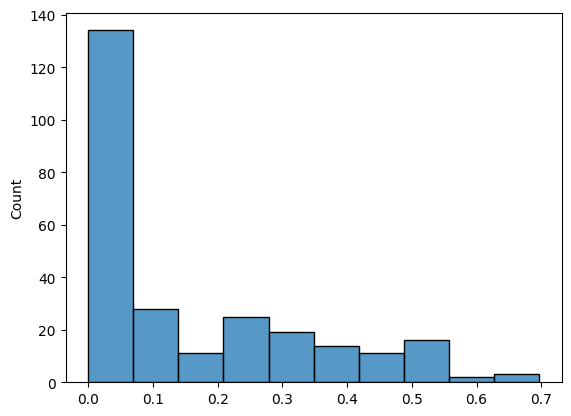

CPU times: user 1.55 s, sys: 770 ms, total: 2.32 s
Wall time: 24.4 s


(66,
 Index(['ip.src_host__nunique', 'ip.dst_host__nunique',
        'icmp.checksum__min_max_diff', 'icmp.checksum__min_max_ratio',
        'icmp.seq_le__min', 'icmp.seq_le__max', 'icmp.seq_le__sum',
        'icmp.seq_le__mean', 'icmp.seq_le__min_max_diff',
        'icmp.seq_le__min_max_ratio', 'icmp.seq_le__min_max_product',
        'icmp.seq_le__mean_square', 'tcp.ack__min', 'tcp.ack__max',
        'tcp.ack__sum', 'tcp.ack__mean', 'tcp.ack__min_max_diff',
        'tcp.ack__min_max_ratio', 'tcp.ack__min_max_product',
        'tcp.ack__mean_square', 'tcp.ack_raw__min', 'tcp.ack_raw__max',
        'tcp.ack_raw__sum', 'tcp.ack_raw__mean', 'tcp.ack_raw__min_max_diff',
        'tcp.ack_raw__min_max_ratio', 'tcp.ack_raw__min_max_product',
        'tcp.ack_raw__mean_square', 'tcp.checksum__max',
        'tcp.checksum__min_max_diff', 'tcp.checksum__min_max_ratio',
        'tcp.connection.syn__sum', 'tcp.connection.syn__mean',
        'tcp.connection.syn__mean_square', 'tcp.connection.synack__

In [21]:
%%time
mi_features = fs_mutual_information(X_fs, y_fs, seed=SEED)
len(mi_features), mi_features

In [22]:
train_xgboost(
    X_train.loc[:, mi_features], y_train, 
    X_valid.loc[:, mi_features], y_valid, 
    seed=SEED,
    method_name='Mutual information', 
    save_dir=MODEL_SAVE_DIR,
    filename=f'mi_dataseed{SEED}.pkl'
)

Evaluation accuracy: 0.9800642554080434
Evaluation precision: 0.958985604395475
Evaluation recall: 0.9808124975192959
Evaluation f1-score: 0.9694114826412636


,model,accuracy,precision,recall,f1-score
0,Mutual information,0.980064,0.958986,0.980812,0.969411


### 5.2 Causality Markov Blanket

  0%|          | 0/9 [00:00<?, ?it/s]

Intermediate number of selected features: 43
Running final selection...


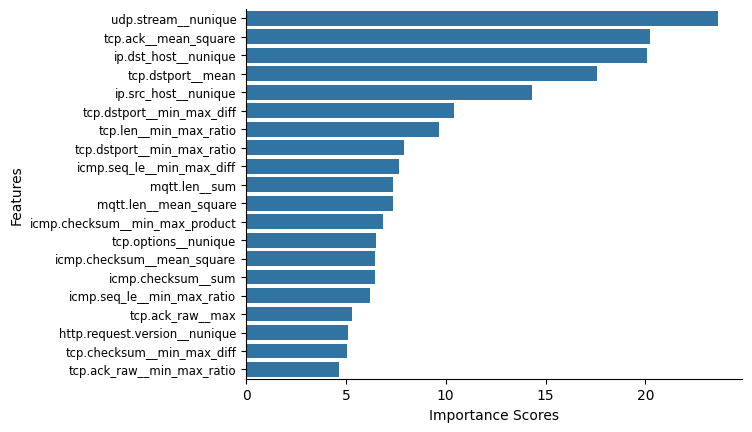

CPU times: user 1.97 s, sys: 423 ms, total: 2.39 s
Wall time: 5min 57s


(20,
 Index(['udp.stream__nunique', 'tcp.ack__mean_square', 'ip.dst_host__nunique',
        'tcp.dstport__mean', 'ip.src_host__nunique',
        'tcp.dstport__min_max_diff', 'tcp.len__min_max_ratio',
        'tcp.dstport__min_max_ratio', 'icmp.seq_le__min_max_diff',
        'mqtt.len__sum', 'mqtt.len__mean_square',
        'icmp.checksum__min_max_product', 'tcp.options__nunique',
        'icmp.checksum__mean_square', 'icmp.checksum__sum',
        'icmp.seq_le__min_max_ratio', 'tcp.ack_raw__max',
        'http.request.version__nunique', 'tcp.checksum__min_max_diff',
        'tcp.ack_raw__min_max_ratio'],
       dtype='object'))

In [23]:
%%time
causal_selected_features = fs_markov_blanket(X_fs, y_fs, modules, seed=SEED, thresholds=[0.001, 0.01], val_size=0.1)
len(causal_selected_features), causal_selected_features

In [24]:
train_xgboost(
    X_train.loc[:, causal_selected_features], y_train, 
    X_valid.loc[:, causal_selected_features], y_valid, 
    seed=SEED,
    method_name='Causal MB', 
    save_dir=MODEL_SAVE_DIR,
    filename=f'mb_dataseed{SEED}.pkl'
)

Evaluation accuracy: 0.9770747941593851
Evaluation precision: 0.9519575174404287
Evaluation recall: 0.9793545447409068
Evaluation f1-score: 0.9648233996295502


,model,accuracy,precision,recall,f1-score
0,Causal MB,0.977075,0.951958,0.979355,0.964823


### 5.3 Boruta

In [25]:
%%time
boruta_selected_features = fs_boruta(X_fs, y_fs, seed=SEED, max_iter=30, n_estimators=100)
print(len(boruta_selected_features))
boruta_selected_features.to_list()

Iteration: 	1 / 30
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	2 / 30
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	3 / 30
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	4 / 30
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	5 / 30
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	6 / 30
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	7 / 30
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	8 / 30
Confirmed: 	96
Tentative: 	46
Rejected: 	121
Iteration: 	9 / 30
Confirmed: 	96
Tentative: 	46
Rejected: 	121
Iteration: 	10 / 30
Confirmed: 	96
Tentative: 	46
Rejected: 	121
Iteration: 	11 / 30
Confirmed: 	96
Tentative: 	46
Rejected: 	121
Iteration: 	12 / 30
Confirmed: 	103
Tentative: 	39
Rejected: 	121
Iteration: 	13 / 30
Confirmed: 	103
Tentative: 	39
Rejected: 	121
Iteration: 	14 / 30
Confirmed: 	103
Tentative: 	35
Rejected: 	125
Iteration: 	15 / 30
Confirmed: 	103
Tentative: 	35
Rejected: 	125
Iteration: 	16 / 30
Confirmed: 	107
Tentativ

['ip.src_host__nunique',
 'ip.dst_host__nunique',
 'icmp.checksum__min',
 'icmp.checksum__max',
 'icmp.checksum__sum',
 'icmp.checksum__mean',
 'icmp.checksum__min_max_diff',
 'icmp.checksum__min_max_ratio',
 'icmp.checksum__min_max_product',
 'icmp.checksum__mean_square',
 'icmp.seq_le__min',
 'icmp.seq_le__max',
 'icmp.seq_le__sum',
 'icmp.seq_le__mean',
 'icmp.seq_le__min_max_diff',
 'icmp.seq_le__min_max_ratio',
 'icmp.seq_le__min_max_product',
 'icmp.seq_le__mean_square',
 'http.file_data__nunique',
 'http.content_length__max',
 'http.content_length__sum',
 'http.content_length__mean',
 'http.content_length__min_max_diff',
 'http.content_length__min_max_ratio',
 'http.content_length__mean_square',
 'http.request.uri.query__nunique',
 'http.request.method__nunique',
 'http.request.full_uri__nunique',
 'http.request.version__nunique',
 'http.response__sum',
 'http.response__min_max_diff',
 'tcp.ack__min',
 'tcp.ack__max',
 'tcp.ack__sum',
 'tcp.ack__mean',
 'tcp.ack__min_max_diff',


In [26]:
train_xgboost(
    X_train.loc[:, boruta_selected_features], y_train, 
    X_valid.loc[:, boruta_selected_features], y_valid, 
    seed=SEED,
    method_name='Boruta', 
    save_dir=MODEL_SAVE_DIR,
    filename=f'boruta_dataseed{SEED}.pkl'
)

Evaluation accuracy: 0.9800426448448002
Evaluation precision: 0.9600722264789983
Evaluation recall: 0.9810639365402448
Evaluation f1-score: 0.9700853607239182


,model,accuracy,precision,recall,f1-score
0,Boruta,0.980043,0.960072,0.981064,0.970085


### 5.4 Recursive Feature Elimination (RFE)

In [27]:
%%time
rfe_selected_features = fs_rfe(X_fs, y_fs, n_features_to_select=len(causal_selected_features), seed=SEED)
len(rfe_selected_features), rfe_selected_features

CPU times: user 13min 45s, sys: 2.19 s, total: 13min 48s
Wall time: 13min 47s


(20,
 Index(['ip.dst_host__nunique', 'icmp.checksum__mean',
        'icmp.checksum__min_max_ratio', 'icmp.seq_le__mean',
        'icmp.seq_le__min_max_diff', 'icmp.seq_le__min_max_ratio',
        'tcp.ack__max', 'tcp.ack__mean', 'tcp.ack_raw__max',
        'tcp.checksum__min_max_diff', 'tcp.dstport__max', 'tcp.dstport__sum',
        'tcp.dstport__min_max_diff', 'tcp.dstport__min_max_product',
        'tcp.len__min_max_diff', 'tcp.options__nunique', 'tcp.seq__max',
        'udp.port__nunique', 'udp.stream__nunique', 'mqtt.len__min_max_ratio'],
       dtype='object'))

In [28]:
train_xgboost(
    X_train.loc[:, rfe_selected_features], y_train, 
    X_valid.loc[:, rfe_selected_features], y_valid, 
    seed=SEED,
    method_name=f'RFE {len(rfe_selected_features)} features', 
    save_dir=MODEL_SAVE_DIR,
    filename=f'rfe_dataseed{SEED}.pkl'
)

Evaluation accuracy: 0.9789315017180398
Evaluation precision: 0.9558700006123384
Evaluation recall: 0.9800729137010198
Evaluation f1-score: 0.9673641131690459


,model,accuracy,precision,recall,f1-score
0,RFE 20 features,0.978932,0.95587,0.980073,0.967364


### 5.5 Random Features

In [29]:
%%time
df_results_random = random_features(
    X_train, y_train, 
    X_valid, y_valid, 
    n_features_to_select=len(causal_selected_features), 
    model_save_dir=MODEL_SAVE_DIR,
    data_seed=SEED,
    ml_seed=SEED
)

	Round: 0 Selected features: Index(['tcp.flags.ack__min', 'dns.retransmit_request__mean_square',
       'mqtt.len__min_max_diff', 'arp.opcode__min_max_ratio', 'tcp.seq__mean',
       'dns.qry.name.len__nunique', 'http.response__min_max_product',
       'mqtt.protoname__nunique', 'tcp.flags__min_max_ratio',
       'tcp.srcport__nunique', 'dns.retransmit_request__mean',
       'tcp.seq__mean_square', 'mqtt.msg__nunique', 'http.content_length__min',
       'dns.retransmit_request_in__min_max_product',
       'tcp.ack__min_max_product', 'tcp.ack__sum'],
      dtype='object')
	Round: 1 Selected features: Index(['udp.time_delta__min_max_diff', 'dns.qry.qu__min',
       'tcp.dstport__mean_square', 'http.content_length__max',
       'tcp.ack_raw__min_max_diff', 'tcp.seq__min_max_ratio',
       'udp.time_delta__mean', 'tcp.ack__mean_square',
       'http.request.full_uri__nunique', 'tcp.srcport__nunique',
       'tcp.connection.fin__sum', 'dns.qry.type__mean',
       'dns.qry.type__mean_square'

	Round: 15 Selected features: Index(['udp.time_delta__min', 'tcp.connection.fin__max', 'tcp.len__mean',
       'tcp.flags.ack__min_max_diff', 'mqtt.topic_len__min_max_ratio',
       'tcp.flags.ack__max', 'http.content_length__min_max_ratio',
       'udp.time_delta__min_max_diff', 'mqtt.len__min_max_product',
       'tcp.connection.rst__sum', 'mqtt.len__mean', 'arp.opcode__mean',
       'http.content_length__sum', 'tcp.connection.fin__min_max_ratio',
       'dns.retransmission__sum', 'mqtt.conflags__mean_square',
       'tcp.ack_raw__min'],
      dtype='object')
	Round: 16 Selected features: Index(['tcp.connection.syn__mean', 'tcp.payload__nunique',
       'dns.retransmission__min', 'http.response__min_max_product',
       'tcp.connection.synack__mean', 'udp.time_delta__mean_square',
       'mqtt.topic_len__max', 'mqtt.topic_len__min',
       'mqtt.conflag.cleansess__min_max_diff', 'mqtt.hdrflags__mean',
       'dns.qry.qu__sum', 'arp.opcode__max', 'tcp.connection.rst__mean',
       'tc

CPU times: user 6min 58s, sys: 531 ms, total: 6min 59s
Wall time: 1min 12s


In [30]:
df_results_random.drop(columns=['model']).describe()

,accuracy,precision,recall,f1-score
count,30.000000,30.000000,30.000000,30.000000
mean,0.752692,0.778490,0.801527,0.725515
std,0.174488,0.087504,0.137655,0.169533
min,0.339880,0.639565,0.520622,0.385584
25%,0.602882,0.712243,0.665491,0.564159
50%,0.804343,0.768737,0.854159,0.794329
75%,0.908887,0.840365,0.930570,0.871194
max,0.973984,0.944235,0.967168,0.954985


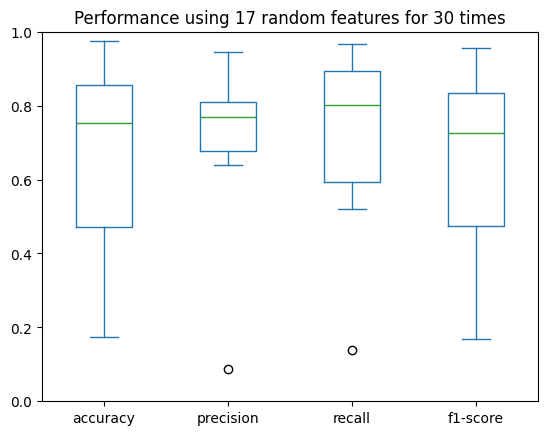

In [31]:
df_results_random.drop(columns=['model']).describe().iloc[1:].plot.box()
plt.title(f'Performance using {len(causal_selected_features)} random features for 30 times')
plt.ylim((0, 1))
plt.show()